In [1]:
!mkdir -p ~/.kaggle

In [2]:
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0
 98% 757M/775M [00:03<00:00, 177MB/s]
100% 775M/775M [00:04<00:00, 165MB/s]


In [5]:
!unzip dog-and-cat-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: PetImages/Dog/5499.jpg  
  inflating: PetImages/Dog/55.jpg    
  inflating: PetImages/Dog/550.jpg   
  inflating: PetImages/Dog/5500.jpg  
  inflating: PetImages/Dog/5501.jpg  
  inflating: PetImages/Dog/5502.jpg  
  inflating: PetImages/Dog/5503.jpg  
  inflating: PetImages/Dog/5504.jpg  
  inflating: PetImages/Dog/5505.jpg  
  inflating: PetImages/Dog/5506.jpg  
  inflating: PetImages/Dog/5507.jpg  
  inflating: PetImages/Dog/5508.jpg  
  inflating: PetImages/Dog/5509.jpg  
  inflating: PetImages/Dog/551.jpg   
  inflating: PetImages/Dog/5510.jpg  
  inflating: PetImages/Dog/5511.jpg  
  inflating: PetImages/Dog/5512.jpg  
  inflating: PetImages/Dog/5513.jpg  
  inflating: PetImages/Dog/5514.jpg  
  inflating: PetImages/Dog/5515.jpg  
  inflating: PetImages/Dog/5516.jpg  
  inflating: PetImages/Dog/5517.jpg  
  inflating: PetImages/Dog/5518.jpg  
  inflating: PetImages/Dog/5519.jpg  
  inflating: PetImages/Dog/552.jpg   

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten
import os
import shutil

In [17]:
cat_path="/content/PetImages/Cat"
dog_path="/content/PetImages/Dog"

dst_cat="/content/PetImages/test/Cat"
dst_dog="/content/PetImages/test/Dog"

In [18]:
# for cat split to make test folder for cat
list_cat=[]

for images in os.listdir(cat_path):
  list_cat.append(images)

cat_train,cat_test=train_test_split(list_cat,test_size=0.2,random_state=42)

list_dog=[]
for images in os.listdir(dog_path):
  list_dog.append(images)

dog_train,dog_test=train_test_split(list_dog,test_size=0.2,random_state=42)

In [19]:
# put in test folder/Cat and Dog
for files in cat_test:
  src=cat_path+'/'+files
  dst=dst_cat+'/'+files
  shutil.move(src,dst)

for files in dog_test:
  src=dog_path+'/'+files
  dst=dst_dog+'/'+files
  shutil.move(src,dst)

In [26]:
print(len(os.listdir('/content/PetImages/train/Dog')))
print(len(os.listdir(dst_dog)))

9999
2500


In [27]:
print(len(os.listdir('/content/PetImages/train/Cat')))
print(len(os.listdir(dst_cat)))

9999
2500


In [81]:
from PIL import Image
import os

folders = [
    "/content/PetImages/train/Cat",
    "/content/PetImages/train/Dog",
    "/content/PetImages/test/Cat",
    "/content/PetImages/test/Dog"
]

for folder in folders:
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        try:
            img = Image.open(file_path)
            # Force all images to RGB
            img = img.convert("RGB")
            img.save(file_path)  # overwrite original
        except Exception as e:
            print("Deleting corrupted image:", file_path, "Error:", e)
            os.remove(file_path)


In [83]:
train_generator=tf.keras.utils.image_dataset_from_directory(
    directory="/content/PetImages/train",
    labels="inferred",
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    color_mode="rgb"
)

test_generator=tf.keras.utils.image_dataset_from_directory(
    directory="/content/PetImages/test",
    labels="inferred",
    label_mode='int',
    batch_size=32,
    image_size=(256,256),
    color_mode="rgb"
)

Found 19998 files belonging to 2 classes.
Found 4999 files belonging to 2 classes.


In [84]:
def normalize_images(image,label):
  image=tf.cast(image/255.,tf.float32)
  return image,label

train_ds=train_generator.map(normalize_images)
test_ds=test_generator.map(normalize_images)

In [85]:
# now create CNN Model

model=Sequential()

model.add(Conv2D(16,kernel_size=(3,3),padding='valid',activation="relu",input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(64,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [86]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 123008)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     7,872,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,877,729 (30.05 MB)

 Trainable params: 7,877,729 (30.05 MB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history=model.fit(train_ds,epochs=15,validation_data=(test_ds))

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.6165 - loss: 0.7809 - val_accuracy: 0.7363 - val_loss: 0.5349
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7540 - loss: 0.5033 - val_accuracy: 0.7417 - val_loss: 0.5239
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.8090 - loss: 0.4221 - val_accuracy: 0.7664 - val_loss: 0.4972
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8582 - loss: 0.3376 - val_accuracy: 0.7656 - val_loss: 0.5683
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 61ms/step - accuracy: 0.8962 - loss: 0.2483 - val_accuracy: 0.7471 - val_loss: 0.6783
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.9381 - loss: 0.1560 - val_accuracy: 0.7447 - val_loss: 0.9742
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9613 - loss: 0.1027 - val_accuracy: 0.7568 - val_loss: 1.0031
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - accuracy: 0.9767 - loss: 0.0673 - 

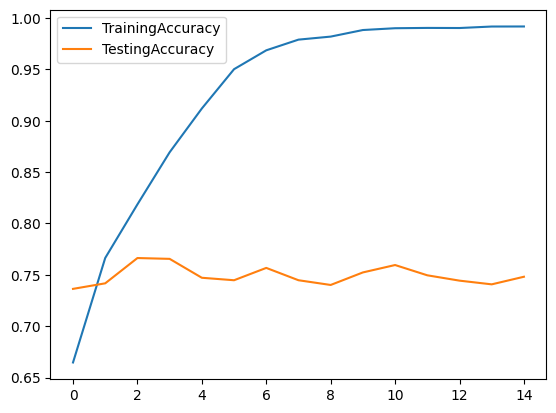

In [94]:
plt.plot(history.history["accuracy"],label="TrainingAccuracy")
plt.plot(history.history["val_accuracy"],label="TestingAccuracy")
plt.legend()

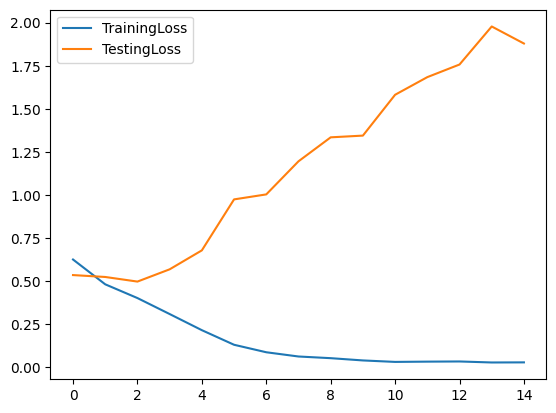

In [95]:
plt.plot(history.history["loss"],label="TrainingLoss")
plt.plot(history.history["val_loss"],label="TestingLoss")
plt.legend()

In [89]:
# now apply some overfitting techniques
#some technqiues

#Add more data
#Data Augmentation
#L1/L2 Regularizer
#Dropout
#BatchNorm
# Reduce Complexity

In [97]:
#apply regularizer l2 and dropout
model2=Sequential()

model2.add(Conv2D(16,kernel_size=(3,3),padding='valid',activation="relu",kernel_regularizer=l2(0.03),input_shape=(256,256,3)))
model2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model2.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation="relu",kernel_regularizer=l2(0.03)))
model2.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))
model2.add(Dropout())

model2.add(Flatten())

model2.add(Dense(64,activation="relu"))
model2.add(Dropout(0.3))
model2.add(Dense(1,activation="sigmoid"))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [98]:
model2.compile(loss="binary_crossentropy",optimizer="adam",metrics=["accuracy"])

history=model2.fit(train_ds,epochs=15,validation_data=(test_ds))

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.5847 - loss: 1.2601 - val_accuracy: 0.6537 - val_loss: 0.7699
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.6831 - loss: 0.7238 - val_accuracy: 0.6929 - val_loss: 0.6640
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 62ms/step - accuracy: 0.7360 - loss: 0.6054 - val_accuracy: 0.7229 - val_loss: 0.6035
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.7829 - loss: 0.5113 - val_accuracy: 0.7323 - val_loss: 0.6629
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - accuracy: 0.8384 - loss: 0.4145 - val_accuracy: 0.7265 - val_loss: 0.6789
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.8996 - loss: 0.3098 - val_accuracy: 0.7185 - val_loss: 0.8160
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 54ms/step - accuracy: 0.9394 - loss: 0.2269 - val_accuracy: 0.7127 - val_loss: 0.9692
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9603 - loss: 0.1776 - 